# Energy volume curve
## Theory 
By fitting the energy-volume curve, we can determine several equilibrium properties, including the equilibrium energy $E_0$, equilibrium volume $V_0$, equilibrium bulk modulus $B_0$, and its derivative $B_0'$. These properties are then utilized in the Einstein model to provide an initial estimation for the thermodynamic properties, namely the heat capacity $C_v$ and the free energy $F$.

## Initialisation

We start by importing matplotlib, numpy and the pyiron project class. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pyiron import Project
%matplotlib inline 

In the next step we create a project, by specifying its relative path/name.

In [2]:
pr = Project('thermo')

## Atomistic structure

To analyse the energy volume dependence a single super cell is sufficient, so we create an iron super cell as an example.

In [3]:
basis = pr.create.structure.bulk(name='Fe', cubic=True, a=2.75)
basis.plot3d()

NGLWidget()

## Murnaghan Module 

Energy volume curves are commonly calculated with ab-initio simulation codes. In this example, we use [GPAW](https://wiki.fysik.dtu.dk/gpaw/), but the functionality below would work just as well with any DFT code, just by changing the job name prefix `Gpaw` to the DFT code of your choice (e.g. VASP, SPHInX...). In this tutorial, we select an energy cutoff of 320 eV, but the simulation would run without changing any parameter. For the rest of the DFT parameters, you can look up functions starting with `job.set_*`.

In order to launch a set of DFT calculations with varying volumes and do the analysis afterwards, the Murnaghan module can be used.

In [4]:
dft = pr.create.job.Gpaw(job_name='gpaw')
dft.set_encut(320) # Optional
dft.structure = basis.copy()
murn = dft.create_job(job_type=pr.job_type.Murnaghan, job_name='murn')
murn.input

,Parameter,Value,Comment
0,num_points,11,number of sample points
1,fit_type,polynomial,"['polynomial', 'birch', 'birchmurnaghan', 'mur..."
2,fit_order,3,order of the fit polynom
3,vol_range,0.1,relative volume variation around volume define...
4,axes,"[x, y, z]",Axes along which the strain will be applied
5,strains,None,List of strains that should be calculated. If...


For this tutorial, we change the input parameters as follows, but in principle you can run the simulation without touching the input

In [5]:
murn.input['num_points'] = 7
murn.input['vol_range'] = 0.05

If your environment allows you to launch calculations to a queueing system, it might be useful to set

```python
dft.server.queue = "name_of_the_queue"
dft.server.cores = number_of_cores
dft.server.run_time = run_time_in_secnds
```

In order to setup the queueing system environment, take a look at [this page](https://pyiron.readthedocs.io/en/latest/index.html).

In [6]:
murn.run()

The job murn was saved and received the ID: 19679221
The job murn_0_95 was saved and received the ID: 19679222
The job murn_0_9666667 was saved and received the ID: 19679223
The job murn_0_9833333 was saved and received the ID: 19679224
The job murn_1_0 was saved and received the ID: 19679226
The job murn_1_0166667 was saved and received the ID: 19679227
The job murn_1_0333333 was saved and received the ID: 19679229
The job murn_1_05 was saved and received the ID: 19679230


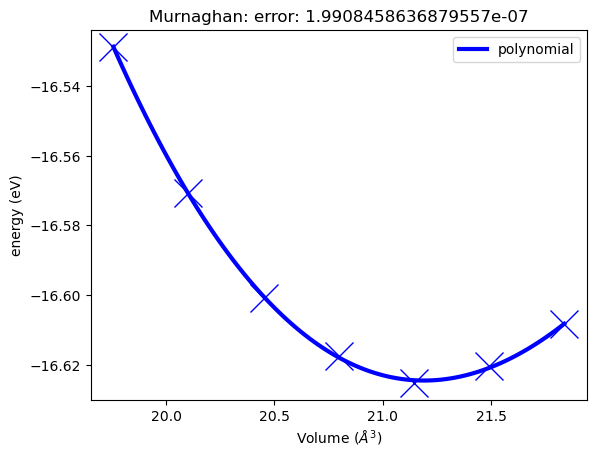

In [8]:
murn.plot();

## Analysis

In pyiron, we offer multiple ways to fit the points: Vinet, Murnaghan, Birch-Murnaghan and polynomial. We show the comparison below:

In [9]:
fit_dict = {
    "Vinet": murn.fit_vinet(),
    "Murnaghan": murn.fit_murnaghan(),
    "Birch-Murnaghan": murn.fit_birch_murnaghan(),
    "Polynomial": murn.fit_polynomial(),
}

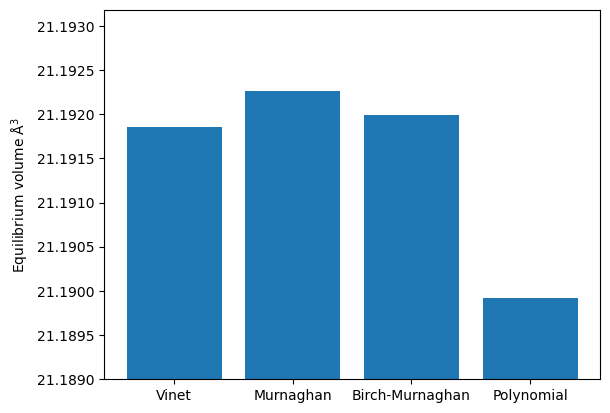

In [10]:
names = list(fit_dict.keys())
volumes = [d["volume_eq"] for d in fit_dict.values()]
plt.ylim([min(volumes) - np.std(volumes), max(volumes) + np.std(volumes)])
plt.ylabel(r"Equilibrium volume $\mathrm{\AA}^3$")
plt.bar(names, volumes);


We can see that the fitting method gives a slight difference in the results. It is important to keep in mind that in DFT calculations the equilibrium volume can easily vary by more than one percent, depending on the type of pseudo-potential used. In this regard, we can consider all of these results to be acceptably correct.

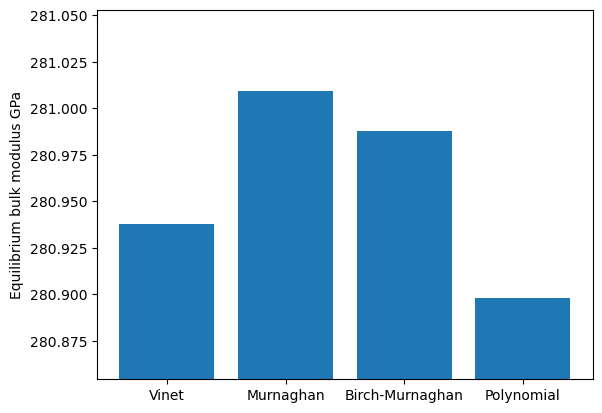

In [11]:
names = list(fit_dict.keys())
volumes = [d["bulkmodul_eq"] for d in fit_dict.values()]
plt.ylim([min(volumes) - np.std(volumes), max(volumes) + np.std(volumes)])
plt.ylabel("Equilibrium bulk modulus GPa")
plt.bar(names, volumes);


## Energy cut-off Dependence

We launched the DFT calculations above using the energy cutoff of 320 eV. However, in order to obtain a physically meaningful result, the energy cutoff (among other plane-wave DFT parameters) should be varied to see the convergence of the output values we are interested in. As the energy cutoff refers to the maximum kinetic energy that is allowed for the plane wave basis functions used to describe the electronic wavefunctions, choosing a higher energy cutoff means including more plane waves in the basis set, which can improve the accuracy of the calculations but also increases the computational cost. Conversely, choosing a lower energy cutoff reduces the computational cost but can lead to less accurate results. Therefore, the energy cutoff is an important parameter in plane wave DFT calculations, and it must be carefully chosen to balance accuracy and computational efficiency for a particular system or calculation. Here, we can take a look at the partial convergence of the equilibrium volume and bulk modulus. For the sake of quick DFT convergence we choose the energy cutoff is chosen between 270 eV and 320 eV (and not higher), but in the scientific context you should see how far you have to go in order to see a true convergence, which applies for other plane-wave DFT parameters (e.g. k-point mesh)

In [12]:
encut_lst = np.linspace(270, 320, 6)

In [13]:
volume_lst = []
bulk_modulus_lst = []
for encut in encut_lst:
    dft = pr.create.job.Gpaw(job_name=('dft', encut))
    dft.set_encut(encut)
    dft.structure = basis.copy()
    murn = dft.create_job(job_type=pr.job_type.Murnaghan, job_name=dft.job_name.replace("dft", "murn"))
    murn.input['num_points'] = 7
    murn.input['vol_range'] = 0.05
    murn.run()
    volume_lst.append(murn.fit_vinet()["volume_eq"])
    bulk_modulus_lst.append(murn.fit_vinet()["bulkmodul_eq"])

The job murn_270d0 was saved and received the ID: 19679231
The job murn_270d0_0_95 was saved and received the ID: 19679233
The job murn_270d0_0_9666667 was saved and received the ID: 19679234
The job murn_270d0_0_9833333 was saved and received the ID: 19679236
The job murn_270d0_1_0 was saved and received the ID: 19679237
The job murn_270d0_1_0166667 was saved and received the ID: 19679238
The job murn_270d0_1_0333333 was saved and received the ID: 19679242
The job murn_270d0_1_05 was saved and received the ID: 19679244
The job murn_280d0 was saved and received the ID: 19679245
The job murn_280d0_0_95 was saved and received the ID: 19679246
The job murn_280d0_0_9666667 was saved and received the ID: 19679249
The job murn_280d0_0_9833333 was saved and received the ID: 19679250
The job murn_280d0_1_0 was saved and received the ID: 19679252
The job murn_280d0_1_0166667 was saved and received the ID: 19679253
The job murn_280d0_1_0333333 was saved and received the ID: 19679255
The job murn

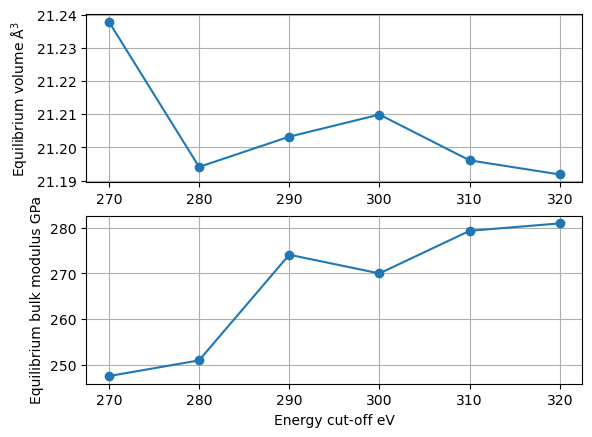

In [14]:
plt.subplot(2, 1, 1)
plt.grid()
plt.ylabel(r"Equilibrium volume $\mathrm{\AA}^3$")
plt.plot(encut_lst, volume_lst, "-o");
plt.subplot(2, 1, 2)
plt.grid()
plt.ylabel("Equilibrium bulk modulus GPa")
plt.xlabel("Energy cut-off eV")
plt.plot(encut_lst, bulk_modulus_lst, "-o");